# Slime Volleyball Agent Training
This notebook implements training for the Slime Volleyball environment using the Cross Entropy Method (CEM).

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime
import cv2
from IPython.display import display, HTML, clear_output
import time
from matplotlib import animation
import gym
import os

# Monkey patch the gym registration function to handle duplicate registrations
original_register = gym.envs.registration.register

def patched_register(id, **kwargs):
    if id in gym.envs.registry.env_specs:
        return
    return original_register(id, **kwargs)

# Apply the patch
gym.envs.registration.register = patched_register

# Now import slimevolleygym
import slimevolleygym

# Create environment
env = gym.make('SlimeVolley-v0')

# Import our training modules
from models.cem_model import CEMAgent
from training.train_cem import train_cem

In [2]:
# Set up device for PyTorch
def get_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA GPU")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = get_device()

Using MPS (Apple Silicon GPU)


## Environment Information
The Slime Volleyball environment provides:
- Observation space: 12-dimensional state vector containing:
  - Agent position (x, y) and velocity (vx, vy)
  - Ball position (x, y) and velocity (vx, vy)
  - Opponent position (x, y) and velocity (vx, vy)
- Action space: 3 binary actions [forward, backward, jump]
- Reward: +1 for scoring, -1 for being scored on
- Episode ends when one player scores

In [3]:
# Print environment details
print("Environment Information:")
print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space}")

# Initialize the CEM agent with correct parameters
agent = CEMAgent(
    state_dim=env.observation_space.shape[0],
    action_dim=3,  # [forward, backward, jump]
    population_size=50,  # Size of the population for CEM
    elite_ratio=0.2,    # Top 20% are elite
    noise_std=0.1,      # Standard deviation of noise
    learning_rate=0.01  # Learning rate for parameter updates
)

print("\nAgent Architecture:")
print(f"Input dimensions: {env.observation_space.shape[0]}")
print(f"Output dimensions: {env.action_space.n}")
print(f"Population size: {agent.population_size}")
print(f"Elite ratio: {agent.elite_ratio}")

Environment Information:
Observation Space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (12,), float32)
Action Space: MultiBinary(3)
Using device: mps

Agent Architecture:
Input dimensions: 12
Output dimensions: 3
Population size: 50
Elite ratio: 0.2


## Environment Test
Let's test the environment by running a few random actions and displaying the results.

In [4]:
def test_environment(env, num_steps=300):  # 10 seconds at 30 FPS
    frames = []
    total_reward = 0
    state = env.reset()
    
    print("Running environment test...")
    for step in range(num_steps):
        # Random action: one hot vector
        action = np.zeros(3)
        action[np.random.randint(3)] = 1  # Set one action to 1
        
        # Step environment
        state, reward, done, _ = env.step(action)
        total_reward += reward
        
        # Render and capture frame
        try:
            frame = env.render(mode='rgb_array')
            frames.append(frame)
        except Exception as e:
            print(f"Warning: Could not render frame: {e}")
            continue
        
        if done:
            print(f"Episode finished after {step} steps with reward {total_reward}")
            state = env.reset()
            total_reward = 0
    
    env.close()
    return frames

# Run test and create animation
try:
    frames = test_environment(env)
    
    if frames:
        # Create animation
        fig = plt.figure(figsize=(10, 6))
        patch = plt.imshow(frames[0])
        plt.axis('off')
        plt.title('Slime Volleyball Environment Test')

        def animate(i):
            patch.set_array(frames[i])
            return [patch]

        anim = animation.FuncAnimation(
            fig, animate, frames=len(frames),
            interval=1000/30,  # 30 FPS
            blit=True
        )

        plt.close()
        display(HTML(anim.to_jshtml()))
    else:
        print("No frames were captured. Please check if XQuartz is running and properly configured.")
except Exception as e:
    print(f"Error during environment test: {e}")
    print("Please make sure XQuartz is running and properly configured.")

Running environment test...
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'
    
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'
    
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x90

## Training Configuration
Set up the hyperparameters for training the agent using CEM.

In [5]:
# Training hyperparameters
hyperparameters = {
    'num_episodes': 100,      # Total episodes to train
    'batch_size': 16,         # Episodes per batch
    'elite_frac': 0.2,        # Top fraction of episodes to use for update
    'eval_interval': 10,      # Episodes between evaluations
    'save_interval': 20,      # Episodes between model saves
}

print("Training Configuration:")
for key, value in hyperparameters.items():
    print(f"{key}: {value}")

Training Configuration:
num_episodes: 100
batch_size: 16
elite_frac: 0.2
eval_interval: 10
save_interval: 20


## Training Loop
Train the agent using the Cross Entropy Method:
1. Run multiple episodes with the current policy
2. Select the top performing episodes
3. Update the policy using the elite episodes
4. Repeat

Using device: mps
Using device: mps

Starting self-play training:
- 100 total episodes
- 300 population size (from 100)
- 0.75 initial exploration noise (from 0.3)
- 16 episodes per batch (from 20)
- 0.998 noise decay factor (new feature)
- Slower noise decay for sustained exploration
- Both agents start from scratch and improve together
- Agents will occasionally play against the built-in policy to measure progress
- A 'hall of fame' of past versions will be maintained for training diversity
- The best performing agent will be saved for evaluation



Self-Play Training:   2%|▏         | 32/2000 [00:13<16:29,  1.99it/s, agent_reward=0.00, opp_reward=0.00, best=0.00]


New best model saved with mean reward: 0.00
Added new model to hall of fame (size: 1)


Self-Play Training:   3%|▎         | 64/2000 [00:26<15:20,  2.10it/s, agent_reward=0.20, opp_reward=-0.20, best=0.20]


New best model saved with mean reward: 0.20
Added new model to hall of fame (size: 2)


Self-Play Training:   5%|▍         | 96/2000 [00:39<16:30,  1.92it/s, agent_reward=-0.20, opp_reward=0.20, best=0.20]

Added new model to hall of fame (size: 3)


Self-Play Training:   5%|▌         | 100/2000 [00:42<13:30,  2.34it/s, agent_reward=-0.20, opp_reward=0.20, best=0.20]


Evaluation vs baseline at episode 100: Mean reward = -5.00

Training interrupted by user
Model saved to saved_models/cem_volleyball.pt
Self-play training complete!

Final Evaluation against built-in opponent:


Evaluation episode 1: Reward = -4.00
Evaluation episode 2: Reward = -4.00
Evaluation episode 3: Reward = -5.00
Evaluation episode 4: Reward = -5.00
Evaluation episode 5: Reward = -5.00
Evaluation episode 6: Reward = -5.00
Evaluation episode 7: Reward = -5.00
Evaluation episode 8: Reward = -5.00
Evaluation episode 9: Reward = -5.00
Evaluation episode 10: Reward = -5.00
Final Mean Reward vs built-in: -4.80
Final Std Reward: 0.40
Min/Max Reward: -5.00/-4.00
Training Duration: 42.72 seconds
Best Reward vs Built-in: -5.0


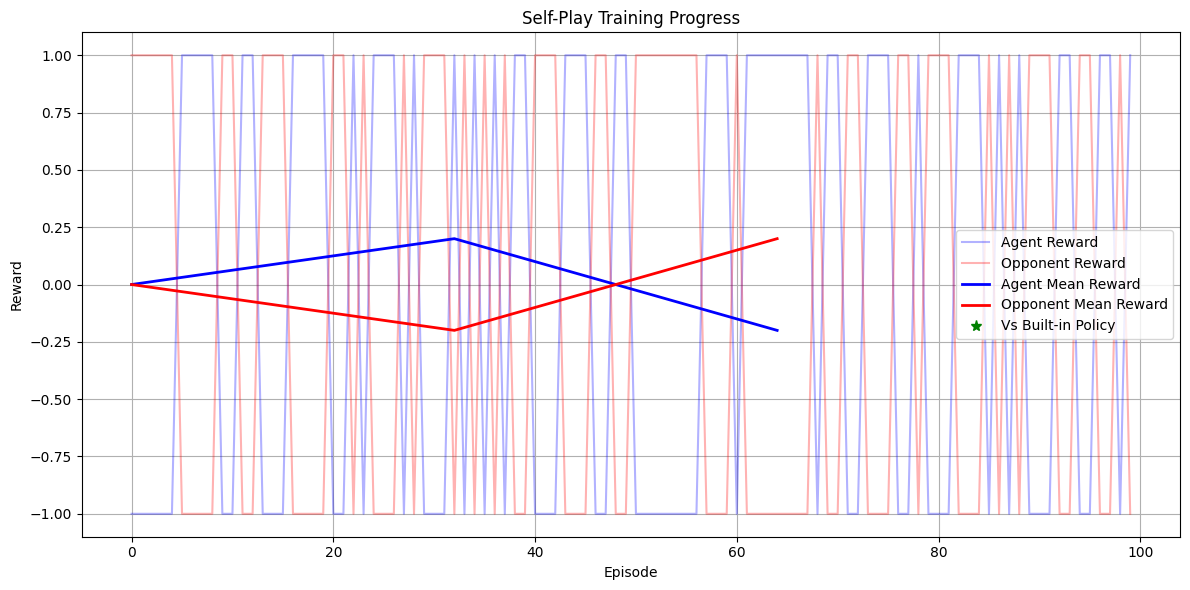

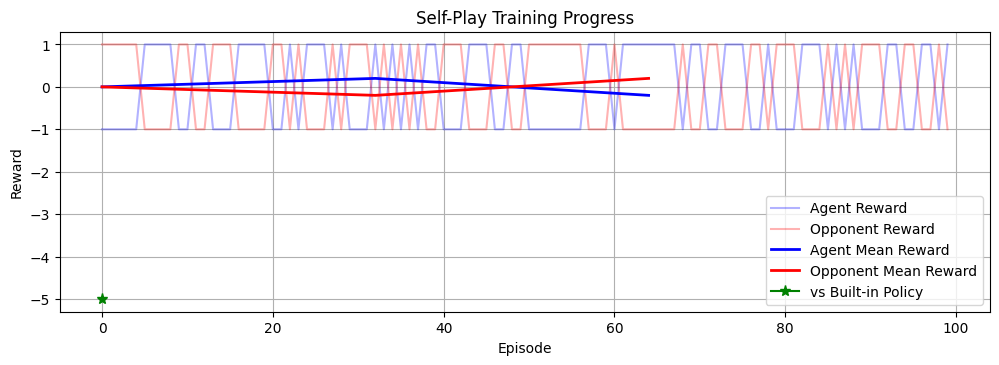

In [6]:
# Create save directory if it doesn't exist
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

# Make sure device is properly initialized
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Set up self-play hyperparameters
selfplay_hyperparameters = {
    'num_episodes': 2000,     # Self-play tends to need more episodes
    'batch_size': 32,        # Larger batch size for more stable updates
    'elite_frac': 0.15,       # Use more elite samples
    'eval_interval': 100,     # Evaluate against baseline periodically
    'save_interval': 200     # Save more frequently
}

# Reinitialize the agent with better parameters
state_dim = env.observation_space.shape[0]
action_dim = 3  # SlimeVolley has 3 binary actions: forward, backward, jump

# Import the existing CEM agent
from models.cem_model import CEMAgent

# Create agent with improved hyperparameters
agent = CEMAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    population_size=300,
    elite_ratio=0.15,
    noise_std=0.75,          # Higher exploration noise
    learning_rate=0.015,
    device=str(device)
)

# Close any existing plots to avoid conflicts
plt.close('all')

# Import the self-play training function
from training.train_cem import train_selfplay_cem

# Validate that we have a multiagent-compatible environment
if not hasattr(env, 'multiagent') or not env.multiagent:
    print("Warning: Environment may not support multiagent mode. Making sure it's enabled.")
    env.multiagent = True

# Print info about self-play training
print("\nStarting self-play training:")
print(f"- {hyperparameters['num_episodes']} total episodes")
print(f"- {agent.population_size} population size (from 100)")
print(f"- {agent.noise_std:.2f} initial exploration noise (from 0.3)")
print(f"- {hyperparameters['batch_size']} episodes per batch (from 20)")
print(f"- 0.998 noise decay factor (new feature)")
print("- Slower noise decay for sustained exploration")
print("- Both agents start from scratch and improve together")
print("- Agents will occasionally play against the built-in policy to measure progress")
print("- A 'hall of fame' of past versions will be maintained for training diversity")
print("- The best performing agent will be saved for evaluation\n")

# Training loop with self-play
metrics = train_selfplay_cem(
    env=env,
    agent=agent,
    device=device,
    num_episodes=selfplay_hyperparameters['num_episodes'],
    batch_size=selfplay_hyperparameters['batch_size'],
    elite_frac=selfplay_hyperparameters['elite_frac'],
    eval_interval=selfplay_hyperparameters['eval_interval'],
    save_interval=selfplay_hyperparameters['save_interval'],
    save_dir=save_dir
)
print("Self-play training complete!")

# Final evaluation against built-in opponent
print("\nFinal Evaluation against built-in opponent:")
from training.train_cem import evaluate_agent
eval_metrics = evaluate_agent(env, agent, num_episodes=10, render=False)
print(f"Final Mean Reward vs built-in: {eval_metrics['mean_reward']:.2f}")
print(f"Final Std Reward: {eval_metrics['std_reward']:.2f}")
print(f"Min/Max Reward: {eval_metrics['min_reward']:.2f}/{eval_metrics['max_reward']:.2f}")

# Show final summary plot
plt.ioff()
plt.figure(figsize=(12, 8))

# Plot rewards
plt.subplot(2, 1, 1)
plt.plot(metrics['episode_rewards'], 'b-', alpha=0.3, label='Agent Reward')
plt.plot(metrics['opponent_rewards'], 'r-', alpha=0.3, label='Opponent Reward')

# Plot smoothed mean rewards
mean_x = list(range(0, len(metrics['episode_rewards']), selfplay_hyperparameters['batch_size']))
if len(mean_x) < len(metrics['mean_rewards']):
    mean_x.append(len(metrics['episode_rewards'])-1)
    
plt.plot(mean_x[:len(metrics['mean_rewards'])], metrics['mean_rewards'], 'b-', linewidth=2, label='Agent Mean Reward')
plt.plot(mean_x[:len(metrics['opponent_mean_rewards'])], metrics['opponent_mean_rewards'], 'r-', linewidth=2, label='Opponent Mean Reward')

# Plot evaluation performance
if len(metrics['vs_baseline_rewards']) > 0:
    eval_x = list(range(0, len(metrics['episode_rewards']), selfplay_hyperparameters['eval_interval']))[:len(metrics['vs_baseline_rewards'])]
    plt.plot(eval_x, metrics['vs_baseline_rewards'], 'g*-', markersize=8, label='vs Built-in Policy')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Self-Play Training Progress')
plt.legend()
plt.grid(True)

# Print final statistics
print(f"Training Duration: {metrics['training_duration']:.2f} seconds")
print(f"Best Reward vs Built-in: {max(metrics['vs_baseline_rewards']) if len(metrics['vs_baseline_rewards']) > 0 else 'N/A'}")

# Option to watch trained agent
view_games = False  # Set to True if you want to watch games
if view_games:
    print("\nPlaying a few games with the trained agent...")
    evaluate_agent(env, agent, num_episodes=3, render=True)

## Training Visualization
Plot the training progress and metrics.

In [ ]:
# Plot training metrics
plt.figure(figsize=(15, 5))

# Plot episode rewards
plt.subplot(1, 2, 1)
plt.plot(metrics['episode_rewards'], 'b-', alpha=0.3, label='Episode Reward')
plt.plot(metrics['mean_rewards'], 'r-', label='Moving Average')
plt.fill_between(
    range(len(metrics['mean_rewards'])),
    np.array(metrics['mean_rewards']) - np.array(metrics['std_rewards']),
    np.array(metrics['mean_rewards']) + np.array(metrics['std_rewards']),
    alpha=0.2, color='r'
)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.grid(True)
plt.legend()

# Plot win rate
plt.subplot(1, 2, 2)
window = 10
wins = [r > 0 for r in metrics['episode_rewards']]
win_rate = [sum(wins[max(0, i-window):i])/min(i, window) 
            for i in range(1, len(wins)+1)]
plt.plot(win_rate, 'g-', label='Win Rate')
plt.xlabel('Episode')
plt.ylabel('Win Rate')
plt.title(f'Win Rate (Moving Average, Window={window})')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Save Results
Save the training metrics and configuration for later analysis.

In [ ]:
# Save results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results = {
    'metrics': metrics,
    'hyperparameters': hyperparameters,
    'final_mean_reward': float(np.mean(metrics['episode_rewards'][-10:])),
    'best_reward': float(max(metrics['episode_rewards'])),
    'final_win_rate': win_rate[-1],
    'training_duration': metrics.get('training_duration', 0)
}

# Save to file
results_file = f'results/training_results_{timestamp}.json'
os.makedirs('results', exist_ok=True)
with open(results_file, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {results_file}")

# Print summary
print("\nTraining Summary:")
print(f"Final average reward (last 10 episodes): {results['final_mean_reward']:.2f}")
print(f"Best episode reward: {results['best_reward']:.2f}")
print(f"Final win rate: {results['final_win_rate']:.2%}")
print(f"Training duration: {results['training_duration']:.2f} seconds")

In [7]:
import numpy as np
import torch
from typing import List, Dict, Any, Union
import copy

class EnhancedCEMAgent(CEMAgent):
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        population_size: int = 300,
        elite_ratio: float = 0.15,
        noise_std: float = 0.5,
        learning_rate: float = 0.02,
        device: str = None,
        buffer_size: int = 1000  # Size of experience buffer
    ):
        super().__init__(state_dim, action_dim, population_size, elite_ratio, 
                         noise_std, learning_rate, device)
        
        # Experience replay buffer
        self.experience_buffer = []
        self.buffer_size = buffer_size
        self.update_count = 0  # Track number of updates for exploration strategy
        
        # For tracking previous positions (needed for recovery reward)
        self.prev_agent_x = None
        self.prev_ball_x = None
        
    def select_action(self, state) -> np.ndarray:
        """Select action using the current mean parameters with enhanced exploration"""
        # Handle different input types
        if isinstance(state, (int, float)):
            state = np.array([state], dtype=np.float32)
        elif isinstance(state, np.ndarray):
            if state.dtype != np.float32:
                state = state.astype(np.float32)
        elif isinstance(state, list):
            state = np.array(state, dtype=np.float32)
        elif not isinstance(state, torch.Tensor):
            raise TypeError(f"Unsupported state type: {type(state)}")
        
        # Convert to tensor and move to device
        if isinstance(state, np.ndarray):
            state = torch.from_numpy(state).float()
        state = state.to(self.device)
        
        # Ensure state has correct shape
        if state.dim() == 0:
            state = state.unsqueeze(0)
        
        # Get action from mean parameters
        params = self.mean.reshape(self.state_dim, self.action_dim)
        action = torch.matmul(state, params).squeeze()
        
        # Advanced Exploration Strategy
        exploration_phase = min(1.0, self.update_count / 100)
        
        # Initially explore entire action space
        if exploration_phase < 0.3:
            noise = torch.randn_like(action) * self.noise_std
        # Then focus on small refinements to jumping timing
        elif exploration_phase < 0.7:
            noise = torch.zeros_like(action)
            noise[2] = torch.randn(1) * self.noise_std  # Jump action
        # Finally focus on positioning refinements
        else:
            noise = torch.zeros_like(action)
            noise[0:2] = torch.randn(2) * self.noise_std  # Movement actions
        
        action = action + noise
        
        # Track state info for recovery reward
        if len(state) >= 12:  # Full observation
            self.prev_agent_x = state[0].item()
            self.prev_ball_x = state[4].item()
        
        # Clip actions to [-1, 1] range
        action = torch.clamp(action, -1, 1)
        
        return action.cpu().numpy()
    
    def update(self, states: List[np.ndarray], actions: List[np.ndarray], 
               rewards: List[float], elite_frac: float = None) -> dict:
        """Update parameters using CEM with experience replay"""
        self.update_count += 1  # Increment update counter
        
        # Store successful experiences
        episode_return = sum(rewards) if isinstance(rewards, list) else rewards.sum()
        if episode_return > 0:  # Only store successful episodes
            self.experience_buffer.append((states, actions, rewards))
            if len(self.experience_buffer) > self.buffer_size:
                self.experience_buffer.pop(0)  # Remove oldest
        
        # Mix current and replay experiences
        if len(self.experience_buffer) > 0 and np.random.random() < 0.3:
            replay_idx = np.random.randint(len(self.experience_buffer))
            replay_states, replay_actions, replay_rewards = self.experience_buffer[replay_idx]
            
            # Augment current batch with replay
            # Ensure proper conversion to numpy arrays
            if isinstance(states, list) and isinstance(replay_states, list):
                # If both are lists, convert to arrays before concatenation
                states_np = np.array([np.array(s, dtype=np.float32) for s in states])
                replay_states_np = np.array([np.array(s, dtype=np.float32) for s in replay_states])
                states = np.concatenate([states_np, replay_states_np])
            else:
                # If they're already arrays, ensure they have compatible shapes
                if isinstance(states, list):
                    states = np.array([np.array(s, dtype=np.float32) for s in states])
                if isinstance(replay_states, list):
                    replay_states = np.array([np.array(s, dtype=np.float32) for s in replay_states])
                states = np.concatenate([states, replay_states])
            
            # Same for actions
            if isinstance(actions, list) and isinstance(replay_actions, list):
                actions_np = np.array([np.array(a, dtype=np.float32) for a in actions])
                replay_actions_np = np.array([np.array(a, dtype=np.float32) for a in replay_actions])
                actions = np.concatenate([actions_np, replay_actions_np])
            else:
                if isinstance(actions, list):
                    actions = np.array([np.array(a, dtype=np.float32) for a in actions])
                if isinstance(replay_actions, list):
                    replay_actions = np.array([np.array(a, dtype=np.float32) for a in replay_actions])
                actions = np.concatenate([actions, replay_actions])
            
            # And for rewards
            if isinstance(rewards, list) and isinstance(replay_rewards, list):
                rewards = np.concatenate([np.array(rewards, dtype=np.float32), 
                                         np.array(replay_rewards, dtype=np.float32)])
            else:
                if isinstance(rewards, list):
                    rewards = np.array(rewards, dtype=np.float32)
                if isinstance(replay_rewards, list):
                    replay_rewards = np.array(replay_rewards, dtype=np.float32)
                rewards = np.concatenate([rewards, replay_rewards])
        
        # Continue with existing update logic from parent class
        return super().update(states, actions, rewards, elite_frac)

In [8]:
class EnhancedSlimeVolleyEnv(slimevolleygym.SlimeVolleyEnv):
    def reset_with_scenarios(self, scenario_type=None):
        """Reset the environment with specific ball scenarios"""
        if scenario_type is None:
            scenario_type = np.random.choice([
                'normal', 'high_ball', 'fast_ball', 'corner_ball', 'net_ball'
            ], p=[0.6, 0.1, 0.1, 0.1, 0.1])
        
        self.t = 0
        self.game.reset()
        
        if scenario_type == 'high_ball':
            self.game.ball.y = slimevolleygym.REF_W/2  # Higher position
            self.game.ball.vy = 5  # Slower vertical speed
        elif scenario_type == 'fast_ball':
            self.game.ball.vx = self.np_random.uniform(-30, 30)  # Faster horizontal
            self.game.ball.vy = self.np_random.uniform(15, 35)   # Faster vertical
        elif scenario_type == 'corner_ball':
            self.game.ball.x = -slimevolleygym.REF_W/3  # Closer to edge
        elif scenario_type == 'net_ball':
            self.game.ball.x = -slimevolleygym.REF_WALL_WIDTH  # Close to net
            self.game.ball.y = slimevolleygym.REF_WALL_HEIGHT + 1  # Just above net height
        
        return self.getObs()

In [9]:
def train_enhanced_cem(
    env,
    agent,
    num_episodes: int,
    device=None,
    batch_size: int = 20,
    elite_frac: float = 0.2,
    eval_interval: int = 20,
    save_interval: int = 50,
    save_dir: str = "saved_models",
    render: bool = False
) -> Dict[str, List[float]]:
    """
    Train the CEM agent with enhanced volleyball-specific reward shaping
    
    Args:
        env: The volleyball environment
        agent: The CEM agent
        num_episodes: Number of episodes to train for
        device: The device to use for training (cpu, cuda, or mps)
        batch_size: Number of episodes to collect before updating
        elite_frac: Fraction of episodes to use as elite samples
        eval_interval: How often to evaluate the agent
        save_interval: How often to save the model
        save_dir: Directory to save models in
        render: Whether to render the environment during training
    
    Returns:
        Dictionary containing training metrics
    """
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "cem_volleyball_enhanced.pt")
    best_model_path = os.path.join(save_dir, "cem_volleyball_enhanced_best.pt")
    
    # Handle device properly
    if device is None:
        if torch.backends.mps.is_available():
            device = torch.device("mps")
        elif torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
        print(f"Using device: {device}")
    
    # Ensure agent is using the correct device
    agent.device = device
    agent.mean = agent.mean.to(device)
    agent.std = agent.std.to(device)
    agent.population = agent.population.to(device)
    
    metrics = {
        "episode_rewards": [],
        "mean_rewards": [],
        "std_rewards": [],
        "elite_rewards": [],
        "rally_lengths": [],       # Track rally lengths
        "strategic_placements": [], # Track strategic placements
        "recovery_actions": [],    # Track successful recoveries
        "curriculum_stage": [],    # Track curriculum stage
        "best_reward": float("-inf"),
        "training_duration": 0
    }
    
    start_time = time.time()
    
    # Initialize the plot
    plt.ion()
    fig, ax = plt.subplots(figsize=(12, 6))
    rewards_line, = ax.plot([], [], 'b-', alpha=0.3, label='Episode Reward')
    mean_line, = ax.plot([], [], 'r-', linewidth=2, label='Mean Reward (10 episodes)')
    std_upper, = ax.plot([], [], 'g:', alpha=0.5)
    std_lower, = ax.plot([], [], 'g:', alpha=0.5)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title('Enhanced Training Progress')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    
    # Setup progress bar for entire training
    pbar = tqdm(total=num_episodes, desc="Enhanced Training")
    
    # For tracking best performing agent
    best_mean_reward = float('-inf')
    best_params = None
    
    # For tracking rally statistics
    total_rally_length = 0
    rally_count = 0
    strategic_placements = 0
    recovery_actions = 0
    
    try:
        for batch_num in range(num_episodes):
            # Calculate curriculum stage for progressive rewards
            curriculum_stage = min(1.0, batch_num / 500)  # Ranges from 0 to 1 over 500 episodes
            basic_weight = 1.0 - 0.5 * curriculum_stage  # Reduces from 1.0 to 0.5
            advanced_weight = 0.2 + 0.8 * curriculum_stage  # Increases from 0.2 to 1.0
            
            metrics['curriculum_stage'].append(curriculum_stage)
            
            # Collect batch of episodes
            batch_states = []
            batch_actions = []
            batch_rewards = []
            batch_episode_rewards = []  # Store total episode rewards
            
            for batch_idx in range(batch_size):
                states = []
                actions = []
                rewards = []
                shaped_rewards = []  # For reward shaping
                
                # Use scenario-based reset 20% of the time
                if hasattr(env, 'reset_with_scenarios') and np.random.random() < 0.2:
                    state = env.reset_with_scenarios()
                else:
                    state = env.reset()
                
                done = False
                episode_reward = 0
                
                # Slime volley specific tracking
                prev_ball_x = None
                prev_ball_y = None
                prev_ball_vy = None
                hit_ball = False
                crossed_net = False
                rally_length = 0  # Track length of current rally
                
                # Store agent and opponent x positions for strategic placement
                agent_x = None
                opponent_x = None
                prev_agent_x = None
                prev_ball_x_dist = None
                
                step_count = 0
                while not done:
                    # Increment rally length counter
                    rally_length += 1
                    
                    # Process state
                    if isinstance(state, (int, float)):
                        state = np.array([state], dtype=np.float32)
                    elif not isinstance(state, np.ndarray):
                        state = np.array(state, dtype=np.float32)
                    
                    action = agent.select_action(state)
                    next_state, reward, done, info = env.step(action)
                    
                    # ---- ENHANCED REWARD SHAPING FOR VOLLEYBALL ----
                    shaped_reward = reward  # Start with the original reward
                    
                    # Extract information for reward shaping if we have the full observation
                    if len(state) >= 12:
                        # In SlimeVolley state: [x, y, vx, vy, ball_x, ball_y, ball_vx, ball_vy, op_x, op_y, op_vx, op_vy]
                        agent_x = state[0]
                        agent_y = state[1]
                        agent_vx = state[2]
                        agent_vy = state[3]
                        ball_x = state[4]
                        ball_y = state[5]
                        ball_vx = state[6]
                        ball_vy = state[7]
                        opponent_x = state[8]
                        opponent_y = state[9]
                        opponent_vx = state[10]
                        opponent_vy = state[11]
                        
                        # 1. Reward for being near the ball horizontally (basic reward)
                        dist_to_ball_x = abs(agent_x - ball_x)
                        if dist_to_ball_x < 2.0:
                            shaped_reward += basic_weight * 0.01
                        
                        # 2. Reward for hitting the ball upward (basic reward)
                        if prev_ball_y is not None and prev_ball_vy is not None:
                            # Detect if ball velocity changed significantly (likely a hit)
                            if ball_y > prev_ball_y and ball_vy > 0 and prev_ball_vy < 0 and dist_to_ball_x < 2.0:
                                # Apply rally-length scaling
                                rally_bonus = min(rally_length / 10, 2.0)  # Caps at 2x for rallies over 20 hits
                                shaped_reward += basic_weight * 0.3 * (1 + rally_bonus)
                                hit_ball = True
                        
                        # 3. BIG reward for getting ball across the net (advanced reward)
                        if prev_ball_x is not None:
                            # Ball crossed from agent side to opponent side
                            if prev_ball_x < 0 and ball_x > 0:
                                shaped_reward += advanced_weight * 1.5  # Significant reward for crossing net
                                crossed_net = True
                                
                                # 3.1 Strategic Placement Reward
                                # Calculate opponent distance to predicted landing spot
                                if ball_vy < 0:  # Ball is falling
                                    # Simple physics prediction of landing spot
                                    time_to_ground = max(0, (ball_y - 1.5) / -9.8)
                                    predicted_landing_x = ball_x + ball_vx * time_to_ground
                                    
                                    # If landing spot is far from opponent
                                    opponent_distance = abs(opponent_x - predicted_landing_x)
                                    if opponent_distance > 2.0:  # Ball placed far from opponent
                                        shaped_reward += advanced_weight * 0.5  # Reward strategic placement
                                        strategic_placements += 1
                        
                        # 4. Small reward for moving toward the ball (basic reward)
                        if prev_ball_x is not None:
                            # If ball is moving toward agent
                            if ball_x < 0 and ball_vx < 0:
                                # Reward moving in direction of ball
                                if (agent_x < ball_x and action[0] > 0) or (agent_x > ball_x and action[1] > 0):
                                    shaped_reward += basic_weight * 0.05
                        
                        # 5. Small reward for jumping when ball is above (basic reward)
                        if ball_y > agent_y and action[2] > 0:
                            shaped_reward += basic_weight * 0.05
                        
                        # 6. Recovery Reward
                        if prev_agent_x is not None and prev_ball_x_dist is not None:
                            current_ball_x_dist = abs(agent_x - ball_x)
                            
                            # If ball was far away and agent moved closer to it
                            if prev_ball_x_dist > 3.0 and current_ball_x_dist < prev_ball_x_dist:
                                shaped_reward += basic_weight * 0.15  # Reward recovery effort
                                recovery_actions += 1
                        
                        # Store current positions for next step comparison
                        prev_ball_x = ball_x
                        prev_ball_y = ball_y
                        prev_ball_vy = ball_vy
                        prev_agent_x = agent_x
                        prev_ball_x_dist = dist_to_ball_x
                    
                    # Add original reward for terminal states (point scored)
                    if reward != 0:
                        # Update rally statistics
                        total_rally_length += rally_length
                        rally_count += 1
                        
                        # If agent scored a point, give them the full reward
                        if reward > 0:
                            shaped_reward = reward
                        # If agent lost, penalize more if they never hit the ball or got it over net
                        elif reward < 0:
                            if not hit_ball:
                                shaped_reward = reward * 1.5  # Bigger penalty for not hitting
                            elif not crossed_net:
                                shaped_reward = reward * 1.2  # Smaller penalty for not crossing net
                        
                        # Reset tracking for new point
                        hit_ball = False
                        crossed_net = False
                        rally_length = 0
                    
                    states.append(state)
                    actions.append(action)
                    rewards.append(shaped_reward)  # Use shaped reward
                    
                    episode_reward += reward  # Keep original reward for metrics
                    
                    state = next_state
                    step_count += 1
                
                # Store episode data
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_rewards.extend(rewards)
                batch_episode_rewards.append(episode_reward)
            
            # Convert actions to numpy array first to avoid PyTorch warning
            batch_actions_np = np.array(batch_actions, dtype=np.float32)
            
            # Update the agent
            update_info = agent.update(batch_states, batch_actions_np, batch_rewards, elite_frac)
            
            # Store metrics
            metrics['episode_rewards'].extend(batch_episode_rewards)
            metrics['rally_lengths'].append(total_rally_length / max(1, rally_count))  # Average rally length
            metrics['strategic_placements'].append(strategic_placements)
            metrics['recovery_actions'].append(recovery_actions)
            
            # Reset rally stats for next batch
            total_rally_length = 0
            rally_count = 0
            strategic_placements = 0
            recovery_actions = 0
            
            # Calculate and store running metrics
            start_idx = max(0, len(metrics['episode_rewards']) - 10)
            recent_rewards = metrics['episode_rewards'][start_idx:]
            current_mean = np.mean(recent_rewards)
            current_std = np.std(recent_rewards)
            
            metrics['mean_rewards'].append(current_mean)
            metrics['std_rewards'].append(current_std)
            metrics['elite_rewards'].append(update_info.get('elite_reward', 0))
            
            # Track best parameters
            if current_mean > best_mean_reward:
                best_mean_reward = current_mean
                best_params = agent.mean.clone()
                torch.save({
                    'mean': best_params,
                    'std': agent.std,
                    'reward': best_mean_reward
                }, best_model_path)
                print(f"\nNew best model saved with mean reward: {best_mean_reward:.2f}")
            
            # Update best reward
            metrics['best_reward'] = max(metrics['best_reward'], max(batch_episode_rewards))
            
            # Update progress bar
            batch_mean = np.mean(batch_episode_rewards)
            batch_std = np.std(batch_episode_rewards)
            pbar.set_postfix({
                'mean_reward': f"{batch_mean:.2f}",
                'std': f"{batch_std:.2f}",
                'best': f"{metrics['best_reward']:.2f}"
            })
            pbar.update(1)
            
            # Update the plot
            episodes_x = list(range(len(metrics['episode_rewards'])))
            rewards_line.set_data(episodes_x, metrics['episode_rewards'])
            
            mean_episodes = list(range(0, len(metrics['episode_rewards']), batch_size))
            if len(mean_episodes) < len(metrics['mean_rewards']):
                mean_episodes.append(len(metrics['episode_rewards']) - 1)
                
            mean_line.set_data(mean_episodes[:len(metrics['mean_rewards'])], metrics['mean_rewards'])
            
            # Update standard deviation bands
            if len(metrics['std_rewards']) > 0:
                std_upper.set_data(
                    mean_episodes[:len(metrics['mean_rewards'])], 
                    [m + s for m, s in zip(metrics['mean_rewards'], metrics['std_rewards'])]
                )
                std_lower.set_data(
                    mean_episodes[:len(metrics['mean_rewards'])], 
                    [m - s for m, s in zip(metrics['mean_rewards'], metrics['std_rewards'])]
                )
            
            ax.relim()
            ax.autoscale_view()
            fig.canvas.draw_idle()
            fig.canvas.flush_events()
            
            # Save model periodically
            if (batch_num + 1) % save_interval == 0:
                agent.save(save_path)
                print(f"\nModel saved to {save_path}")
    
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
        agent.save(save_path)
        print(f"Model saved to {save_path}")
    except Exception as e:
        print(f"\nTraining interrupted due to error: {str(e)}")
        agent.save(save_path)
        print(f"Model saved to {save_path}")
        raise e
    
    finally:
        pbar.close()
        plt.ioff()
        metrics['training_duration'] = time.time() - start_time
        
        # Before closing, load best parameters if available
        if best_params is not None:
            agent.mean = best_params
        
        env.close()
        
    return metrics

In [10]:
def train_enhanced_selfplay_cem(
    env,
    agent,
    num_episodes: int,
    device=None,
    batch_size: int = 40,
    elite_frac: float = 0.15,
    eval_interval: int = 100,
    save_interval: int = 200,
    save_dir: str = "saved_models",
    render: bool = False
) -> Dict[str, List[float]]:
    """
    Enhanced self-play training for CEM agent using strategic hall of fame
    
    Args:
        env: SlimeVolley environment (needs to be multiagent compatible)
        agent: The CEM agent for right player
        num_episodes: Number of episodes to train for
        device: Device to use for tensor operations
        batch_size: Episodes per batch before update
        elite_frac: Fraction of elite samples
        eval_interval: Episodes between evaluations
        save_interval: Episodes between model saves
        save_dir: Directory to save models to
        render: Whether to render training
        
    Returns:
        Dictionary of training metrics
    """
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "cem_volleyball_selfplay.pt")
    best_model_path = os.path.join(save_dir, "cem_volleyball_selfplay_best.pt")
    
    # Handle device properly
    if device is None:
        if torch.backends.mps.is_available():
            device = torch.device("mps")
        elif torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
        print(f"Using device: {device}")
    
    # Create second agent for self-play (initially identical)
    opponent_agent = copy.deepcopy(agent)
    
    # Ensure both agents are using the correct device
    agent.device = device
    agent.mean = agent.mean.to(device)
    agent.std = agent.std.to(device)
    agent.population = agent.population.to(device)
    
    opponent_agent.device = device
    opponent_agent.mean = opponent_agent.mean.to(device)
    opponent_agent.std = opponent_agent.std.to(device)
    opponent_agent.population = opponent_agent.population.to(device)
    
    # Historical versions of the agent to train against (for diversity)
    hall_of_fame = []
    
    # Track win rates against each hall of fame member
    hall_of_fame_stats = {}
    
    metrics = {
        "episode_rewards": [],        # Rewards for the main agent
        "opponent_rewards": [],       # Rewards for the opponent agent
        "mean_rewards": [],           # Moving average of main agent rewards
        "opponent_mean_rewards": [],  # Moving average of opponent rewards
        "vs_baseline_rewards": [],    # Occasional evaluation vs built-in policy
        "std_rewards": [],            # Standard deviation of rewards
        "hall_of_fame_size": [],      # Size of hall of fame
        "curriculum_stage": [],       # Curriculum learning stage
        "strategic_placements": [],   # Strategic ball placements
        "recovery_actions": [],       # Successful recovery actions
        "rally_lengths": [],          # Average rally length per batch
        "best_reward": float("-inf"),
        "training_duration": 0
    }
    
    start_time = time.time()
    
    # Initialize the plot
    plt.ion()
    fig, ax = plt.subplots(figsize=(12, 6))
    rewards_line, = ax.plot([], [], 'b-', alpha=0.3, label='Agent Reward')
    opponent_line, = ax.plot([], [], 'r-', alpha=0.3, label='Opponent Reward')
    mean_line, = ax.plot([], [], 'b-', linewidth=2, label='Agent Mean Reward')
    op_mean_line, = ax.plot([], [], 'r-', linewidth=2, label='Opponent Mean Reward')
    eval_line, = ax.plot([], [], 'g*', markersize=8, label='Vs Built-in Policy')
    
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title('Enhanced Self-Play Training Progress')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    
    # Setup progress bar for entire training
    pbar = tqdm(total=num_episodes, desc="Enhanced Self-Play Training")
    
    # For tracking best performing agent
    best_mean_reward = float('-inf')
    best_params = None
    
    # For tracking rally statistics
    total_rally_length = 0
    rally_count = 0
    strategic_placements = 0
    recovery_actions = 0
    
    try:
        for episode in range(num_episodes):
            # Calculate curriculum stage
            curriculum_stage = min(1.0, episode / 500)  # Ranges from 0 to 1 over 500 episodes
            basic_weight = 1.0 - 0.5 * curriculum_stage  # Reduces from 1.0 to 0.5
            advanced_weight = 0.2 + 0.8 * curriculum_stage  # Increases from 0.2 to 1.0
            
            metrics['curriculum_stage'].append(curriculum_stage)
            
            # Decide if we should use a hall of fame opponent
            use_hall_member = False
            if len(hall_of_fame) > 0 and np.random.random() < 0.3:  # 30% chance
                use_hall_member = True
                
                # Choose strategically based on win rates if possible
                if len(hall_of_fame_stats) > 0:
                    # Find opponent that current agent struggles against most
                    weakest_against_idx = min(hall_of_fame_stats, 
                                              key=lambda idx: hall_of_fame_stats[idx])
                    historical_opponent = hall_of_fame[weakest_against_idx]
                else:
                    # Otherwise random selection
                    random_idx = np.random.randint(len(hall_of_fame))
                    historical_opponent = hall_of_fame[random_idx]
                
                # Set opponent to historical version
                opponent_agent.mean = historical_opponent['mean'].clone()
                current_hof_idx = hall_of_fame.index(historical_opponent)
            
            # Collect episode data
            states_right = []
            actions_right = []
            rewards_right = []
            
            states_left = []
            actions_left = []
            rewards_left = []
            
            # Use scenario-based reset 20% of the time
            if hasattr(env, 'reset_with_scenarios') and np.random.random() < 0.2:
                state_right = env.reset_with_scenarios()
            else:
                state_right = env.reset()
                
            # For SlimeVolley, the observation from the left agent's perspective is in info['otherObs']
            _, _, _, info = env.step(np.zeros(3))  # Take a dummy step to get otherObs
            state_left = info['otherObs']
            
            done = False
            episode_reward_right = 0
            episode_reward_left = 0
            
            # Initialize tracking variables for reward shaping
            prev_ball_x = None
            prev_ball_y = None
            prev_ball_vy = None
            hit_count = 0
            successful_hit = False
            crossed_net = False
            
            # For recovery reward
            prev_agent_x = None
            prev_ball_x_dist = None
            
            # For rally length tracking
            rally_length = 0
            
            # Play one episode
            while not done:
                # Increment rally counter
                rally_length += 1
                
                # Process state for right agent
                if isinstance(state_right, (int, float)):
                    state_right = np.array([state_right], dtype=np.float32)
                elif not isinstance(state_right, np.ndarray):
                    state_right = np.array(state_right, dtype=np.float32)
                
                # Process state for left agent
                if isinstance(state_left, (int, float)):
                    state_left = np.array([state_left], dtype=np.float32)
                elif not isinstance(state_left, np.ndarray):
                    state_left = np.array(state_left, dtype=np.float32)
                
                # Select actions for both agents
                action_right = agent.select_action(state_right)
                action_left = opponent_agent.select_action(state_left)
                
                # Take step in environment with both actions
                next_state_right, reward_right, done, info = env.step(action_right, action_left)
                next_state_left = info['otherObs']
                reward_left = -reward_right  # Rewards are opposite in zero-sum game
                
                # Store transitions
                states_right.append(state_right)
                actions_right.append(action_right)
                rewards_right.append(reward_right)
                
                states_left.append(state_left)
                actions_left.append(action_left)
                rewards_left.append(reward_left)
                
                # Enhanced reward shaping for right agent
                shaped_reward_right = reward_right
                
                if len(state_right) >= 12:  # Make sure we have full observation
                    # Extract positions from state
                    agent_x = state_right[0]
                    agent_y = state_right[1]
                    agent_vx = state_right[2]
                    agent_vy = state_right[3]
                    ball_x = state_right[4]
                    ball_y = state_right[5]
                    ball_vx = state_right[6]
                    ball_vy = state_right[7]
                    opponent_x = state_right[8]
                    opponent_y = state_right[9]
                    
                    # Current distance to ball
                    dist_to_ball_x = abs(agent_x - ball_x)
                    
                    # 1. Reward for being in a good position - near where the ball will land
                    if ball_x < 0 and ball_vx < 0:  # Ball moving toward agent
                        # Predict approximately where ball will land
                        time_to_ground = max(0, (ball_y - 1.5) / -9.8)  # Simple physics
                        predicted_x = ball_x + ball_vx * time_to_ground
                        
                        # Distance to predicted landing spot
                        distance_to_landing = abs(agent_x - predicted_x)
                        if distance_to_landing < 2.0:
                            shaped_reward_right += basic_weight * 0.2  # Reward for good positioning
                    
                    # 2. Bigger reward for hitting the ball successfully
                    if prev_ball_y is not None and prev_ball_vy is not None:
                        # Ball was going down but now going up - likely a hit
                        if prev_ball_vy < 0 and ball_vy > 0 and dist_to_ball_x < 2.0:
                            # Apply rally-length scaling
                            rally_bonus = min(rally_length / 10, 2.0)  # Caps at 2x for rallies over 20 hits
                            shaped_reward_right += basic_weight * 0.5 * (1 + rally_bonus)
                            successful_hit = True
                            hit_count += 1
                    
                    # 3. Much bigger reward for getting the ball over the net
                    if prev_ball_x is not None and prev_ball_x < 0 and ball_x > 0:
                        shaped_reward_right += advanced_weight * 1.5  # Very significant reward
                        crossed_net = True
                        
                        # Even more reward if it was intentional (after a successful hit)
                        if successful_hit:
                            shaped_reward_right += advanced_weight * 0.5
                        
                        # Strategic placement reward
                        if ball_vy < 0:  # Ball is falling
                            # Simple physics prediction of landing spot
                            time_to_ground = max(0, (ball_y - 1.5) / -9.8)
                            predicted_landing_x = ball_x + ball_vx * time_to_ground
                            
                            # If landing spot is far from opponent
                            opponent_distance = abs(opponent_x - predicted_landing_x)
                            if opponent_distance > 2.0:  # Ball placed far from opponent
                                shaped_reward_right += advanced_weight * 0.5  # Reward strategic placement
                                strategic_placements += 1
                    
                    # 4. Reward for active movement and jumping at appropriate times
                    # Reward jumping when ball is nearby and above
                    if action_right[2] > 0 and ball_y > agent_y and dist_to_ball_x < 2.0:
                        shaped_reward_right += basic_weight * 0.15
                    
                    # 5. Recovery Reward
                    if prev_agent_x is not None and prev_ball_x_dist is not None:
                        # If ball was far away and agent moved closer to it
                        if prev_ball_x_dist > 3.0 and dist_to_ball_x < prev_ball_x_dist:
                            shaped_reward_right += basic_weight * 0.15  # Reward recovery effort
                            recovery_actions += 1
                    
                    # Store current positions for next step comparison
                    prev_ball_x = ball_x
                    prev_ball_y = ball_y
                    prev_ball_vy = ball_vy
                    prev_agent_x = agent_x
                    prev_ball_x_dist = dist_to_ball_x
                
                # Reset tracking variables when a point is scored
                if reward_right != 0:
                    # Update rally statistics
                    total_rally_length += rally_length
                    rally_count += 1
                    rally_length = 0
                    
                    hit_count = 0
                    successful_hit = False
                    crossed_net = False
                
                # Update rewards with shaped values
                rewards_right[-1] = shaped_reward_right
                # Left agent gets mirrored (negative) shaped rewards
                rewards_left[-1] = -shaped_reward_right
                
                # Update episode rewards (using original rewards for metrics)
                episode_reward_right += reward_right
                episode_reward_left += reward_left
                
                # Update states
                state_right = next_state_right
                state_left = next_state_left
                
                if render:
                    env.render()
            
            # Store episode rewards
            metrics['episode_rewards'].append(episode_reward_right)
            metrics['opponent_rewards'].append(episode_reward_left)
            
            # Update hall of fame stats if we used a hall member
            if use_hall_member:
                # Update win rate against this hall of fame member
                if current_hof_idx not in hall_of_fame_stats:
                    hall_of_fame_stats[current_hof_idx] = 0.5  # Start at 50% win rate
                
                # Update win rate with exponential moving average
                win_indicator = 1.0 if episode_reward_right > 0 else 0.0
                hall_of_fame_stats[current_hof_idx] = 0.9 * hall_of_fame_stats[current_hof_idx] + 0.1 * win_indicator
            
            # Batch complete - update both agents
            if (episode + 1) % batch_size == 0:
                # Store metrics before updates
                metrics['rally_lengths'].append(total_rally_length / max(1, rally_count))
                metrics['strategic_placements'].append(strategic_placements)
                metrics['recovery_actions'].append(recovery_actions)
                metrics['hall_of_fame_size'].append(len(hall_of_fame))
                
                # Reset tracking stats
                total_rally_length = 0
                rally_count = 0
                strategic_placements = 0
                recovery_actions = 0
                
                # Convert actions to numpy arrays
                actions_right_np = np.array(actions_right, dtype=np.float32)
                actions_left_np = np.array(actions_left, dtype=np.float32)
                
                # Update agents
                update_info_right = agent.update(states_right, actions_right_np, rewards_right, elite_frac)
                if not use_hall_member:
                    update_info_left = opponent_agent.update(states_left, actions_left_np, rewards_left, elite_frac)
                
                # Dynamic noise adjustment
                if hasattr(agent, 'noise_std'):
                    agent.noise_std *= 0.998  # Very slow decay
                    agent.noise_std = max(agent.noise_std, 0.05)
                
                if hasattr(opponent_agent, 'noise_std') and not use_hall_member:
                    opponent_agent.noise_std *= 0.998  # Apply same decay to opponent
                    opponent_agent.noise_std = max(opponent_agent.noise_std, 0.05)
                
                start_idx = max(0, len(metrics['episode_rewards']) - 10)
                recent_rewards = metrics['episode_rewards'][start_idx:]
                recent_op_rewards = metrics['opponent_rewards'][start_idx:]
                
                current_mean = np.mean(recent_rewards)
                current_op_mean = np.mean(recent_op_rewards)
                current_std = np.std(recent_rewards)
                
                metrics['mean_rewards'].append(current_mean)
                metrics['opponent_mean_rewards'].append(current_op_mean)
                metrics['std_rewards'].append(current_std)
                
                # Update best reward and save best model
                if current_mean > best_mean_reward:
                    best_mean_reward = current_mean
                    best_params = agent.mean.clone()
                    torch.save({
                        'mean': best_params,
                        'std': agent.std,
                        'reward': best_mean_reward
                    }, best_model_path)
                    print(f"\nNew best model saved with mean reward: {best_mean_reward:.2f}")
                
                # Add current version to hall of fame 
                # More strategic hall of fame management
                if len(hall_of_fame) < 5:
                    # Always add to hall of fame until we have 5 members
                    hall_of_fame.append({
                        'mean': agent.mean.clone(),
                        'performance': current_mean,
                        'age': episode
                    })
                    print(f"Added new model to hall of fame (size: {len(hall_of_fame)})")
                elif np.random.random() < 0.1:  # 10% chance after hall of fame has 5 models
                    # Replace either:
                    # 1. The worst performing member (80% chance)
                    # 2. The oldest member (20% chance)
                    if np.random.random() < 0.8:
                        # Find worst performer
                        hall_of_fame.sort(key=lambda x: x['performance'])
                        print(f"Replacing worst performer in hall of fame (reward: {hall_of_fame[0]['performance']:.2f})")
                        hall_of_fame[0] = {
                            'mean': agent.mean.clone(),
                            'performance': current_mean,
                            'age': episode
                        }
                        # Reset win rate stats for this position
                        if 0 in hall_of_fame_stats:
                            hall_of_fame_stats[0] = 0.5
                    else:
                        # Find oldest member
                        oldest_idx = min(range(len(hall_of_fame)), key=lambda i: hall_of_fame[i]['age'])
                        print(f"Replacing oldest hall of fame member (age: {episode - hall_of_fame[oldest_idx]['age']})")
                        hall_of_fame[oldest_idx] = {
                            'mean': agent.mean.clone(),
                            'performance': current_mean,
                            'age': episode
                        }
                        # Reset win rate stats for this position
                        if oldest_idx in hall_of_fame_stats:
                            hall_of_fame_stats[oldest_idx] = 0.5
                
                # Update progress bar
                pbar.set_postfix({
                    'agent_reward': f"{current_mean:.2f}",
                    'opp_reward': f"{current_op_mean:.2f}",
                    'best': f"{best_mean_reward:.2f}",
                    'hof': f"{len(hall_of_fame)}"
                })
            
            pbar.update(1)
            
            # Update the plot
            if (episode + 1) % 5 == 0:
                episodes_x = list(range(len(metrics['episode_rewards'])))
                rewards_line.set_data(episodes_x, metrics['episode_rewards'])
                opponent_line.set_data(episodes_x, metrics['opponent_rewards'])
                
                mean_x = list(range(0, len(metrics['episode_rewards']), batch_size))
                if len(mean_x) < len(metrics['mean_rewards']):
                    mean_x.append(len(metrics['episode_rewards']) - 1)
                
                mean_line.set_data(mean_x[:len(metrics['mean_rewards'])], metrics['mean_rewards'])
                op_mean_line.set_data(mean_x[:len(metrics['opponent_mean_rewards'])], metrics['opponent_mean_rewards'])
                
                if len(metrics['vs_baseline_rewards']) > 0:
                    eval_x = list(range(0, len(metrics['episode_rewards']), eval_interval))[:len(metrics['vs_baseline_rewards'])]
                    eval_line.set_data(eval_x, metrics['vs_baseline_rewards'])
                
                ax.relim()
                ax.autoscale_view()
                fig.canvas.draw_idle()
                fig.canvas.flush_events()
            
            # Evaluate against built-in opponent periodically
            if (episode + 1) % eval_interval == 0:
                # Reset the environment to ensure we're using the baseline opponent
                env.reset()
                
                # Evaluate for 5 episodes against built-in opponent
                eval_rewards = []
                for _ in range(5):
                    eval_state = env.reset()
                    eval_done = False
                    eval_episode_reward = 0
                    
                    # Use the best parameters found so far for evaluation
                    if best_params is not None:
                        agent.mean = best_params.clone()
                    
                    while not eval_done:
                        if isinstance(eval_state, (int, float)):
                            eval_state = np.array([eval_state], dtype=np.float32)
                        elif not isinstance(eval_state, np.ndarray):
                            eval_state = np.array(eval_state, dtype=np.float32)
                        
                        # Select action (reduced exploration noise)
                        with torch.no_grad():
                            eval_action = agent.select_action(eval_state)
                            
                        # Take step using only our action (built-in opponent is used by default)
                        eval_next_state, eval_reward, eval_done, _ = env.step(eval_action)
                        eval_episode_reward += eval_reward
                        eval_state = eval_next_state
                    
                    eval_rewards.append(eval_episode_reward)
                
                # Store and report evaluation results
                eval_mean = np.mean(eval_rewards)
                metrics['vs_baseline_rewards'].append(eval_mean)
                print(f"\nEvaluation vs baseline at episode {episode + 1}: Mean reward = {eval_mean:.2f}")
            
            # Save model periodically
            if (episode + 1) % save_interval == 0:
                if best_params is not None:
                    agent.mean = best_params.clone()
                agent.save(save_path)
                print(f"\nModel saved to {save_path}")
    
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
        if best_params is not None:
            agent.mean = best_params.clone()
        agent.save(save_path)
        print(f"Model saved to {save_path}")
    except Exception as e:
        print(f"\nTraining interrupted due to error: {str(e)}")
        if best_params is not None:
            agent.mean = best_params.clone()
        agent.save(save_path)
        print(f"Model saved to {save_path}")
        raise e
    
    finally:
        pbar.close()
        plt.ioff()
        metrics['training_duration'] = time.time() - start_time
        
        # Load best parameters before returning
        if best_params is not None:
            agent.mean = best_params.clone()
        
        env.close()
        
    return metrics

In [11]:
# Advanced Visualization Cell
# This cell creates detailed visualizations of the training metrics

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import pandas as pd
from IPython.display import display, HTML

def create_advanced_visualization(metrics, title="Enhanced Training Analysis"):
    """
    Create detailed visualizations of training metrics
    
    Args:
        metrics: Dictionary of training metrics
        title: Title for the visualization
    """
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = [18, 12]
    
    # Create DataFrame for easier plotting
    episode_range = range(len(metrics['episode_rewards']))
    df = pd.DataFrame({
        'Episode': episode_range,
        'Reward': metrics['episode_rewards'],
    })
    
    # Extract other metrics
    batch_size = len(metrics['episode_rewards']) // len(metrics['mean_rewards'])
    batch_episodes = np.arange(0, len(metrics['episode_rewards']), batch_size)
    batch_episodes = batch_episodes[:len(metrics['mean_rewards'])]
    
    # Create a grid layout
    fig = plt.figure(figsize=(22, 16))
    gs = GridSpec(3, 3, figure=fig)
    
    # 1. Main Reward Plot
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(episode_range, metrics['episode_rewards'], 'b-', alpha=0.3, linewidth=1, label='Episode Reward')
    ax1.plot(batch_episodes, metrics['mean_rewards'], 'r-', linewidth=2, label='Mean Reward')
    
    # Add standard deviation bands
    if 'std_rewards' in metrics and len(metrics['std_rewards']) > 0:
        upper_bound = [m + s for m, s in zip(metrics['mean_rewards'], metrics['std_rewards'])]
        lower_bound = [m - s for m, s in zip(metrics['mean_rewards'], metrics['std_rewards'])]
        ax1.fill_between(batch_episodes, upper_bound, lower_bound, color='r', alpha=0.2, label='± 1 Std Dev')
    
    # Add baseline evaluation points if available
    if 'vs_baseline_rewards' in metrics and len(metrics['vs_baseline_rewards']) > 0:
        eval_interval = len(metrics['episode_rewards']) // len(metrics['vs_baseline_rewards'])
        eval_episodes = np.arange(eval_interval-1, len(metrics['episode_rewards']), eval_interval)
        eval_episodes = eval_episodes[:len(metrics['vs_baseline_rewards'])]
        ax1.plot(eval_episodes, metrics['vs_baseline_rewards'], 'g*-', markersize=10, label='vs Built-in Policy')
    
    ax1.set_title('Training Rewards Over Time', fontsize=16)
    ax1.set_xlabel('Episode', fontsize=14)
    ax1.set_ylabel('Reward', fontsize=14)
    ax1.legend(fontsize=12, loc='upper left')
    ax1.grid(True)
    
    # 2. Curriculum Stage and Win Rate
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Calculate win rate
    window = 20
    wins = [r > 0 for r in metrics['episode_rewards']]
    win_rate = [sum(wins[max(0, i-window):i])/min(i, window) for i in range(1, len(wins)+1)]
    
    # Plot win rate and curriculum stage
    ax2.plot(win_rate, 'g-', linewidth=2, label='Win Rate')
    
    if 'curriculum_stage' in metrics and len(metrics['curriculum_stage']) > 0:
        # Create a twin axis for curriculum stage
        ax2_twin = ax2.twinx()
        # Ensure curriculum_stage is the right length
        curriculum_x = range(len(metrics['curriculum_stage']))
        ax2_twin.plot(curriculum_x, metrics['curriculum_stage'], 'r--', linewidth=2, label='Curriculum Stage')
        ax2_twin.set_ylabel('Curriculum Stage', fontsize=14, color='r')
        ax2_twin.tick_params(axis='y', labelcolor='r')
        ax2_twin.set_ylim(0, 1.1)
    
    ax2.set_title('Win Rate & Curriculum Progress', fontsize=16)
    ax2.set_xlabel('Episode', fontsize=14)
    ax2.set_ylabel('Win Rate (Moving Avg)', fontsize=14)
    ax2.set_ylim(0, 1.1)
    ax2.grid(True)
    
    # Add both legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    if 'curriculum_stage' in metrics:
        lines2, labels2 = ax2_twin.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, fontsize=12, loc='upper left')
    else:
        ax2.legend(fontsize=12, loc='upper left')
    
    # 3. Rally Statistics
    ax3 = fig.add_subplot(gs[1, 1])
    
    if 'rally_lengths' in metrics and len(metrics['rally_lengths']) > 0:
        ax3.plot(batch_episodes[:len(metrics['rally_lengths'])], metrics['rally_lengths'], 'b-', linewidth=2)
        ax3.set_title('Average Rally Length', fontsize=16)
        ax3.set_xlabel('Batch', fontsize=14)
        ax3.set_ylabel('Avg Steps per Rally', fontsize=14)
        ax3.grid(True)
        ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        ax3.text(0.5, 0.5, "Rally length data not available", 
                 horizontalalignment='center', fontsize=14)
        ax3.set_title('Rally Statistics', fontsize=16)
    
    # 4. Advanced Strategy Metrics
    ax4 = fig.add_subplot(gs[1, 2])
    
    # Plot strategic placements and recovery actions if available
    if ('strategic_placements' in metrics and len(metrics['strategic_placements']) > 0 and
        'recovery_actions' in metrics and len(metrics['recovery_actions']) > 0):
        
        ax4.plot(batch_episodes[:len(metrics['strategic_placements'])], 
                metrics['strategic_placements'], 'purple', linewidth=2, label='Strategic Placements')
        ax4.plot(batch_episodes[:len(metrics['recovery_actions'])], 
                metrics['recovery_actions'], 'orange', linewidth=2, label='Recovery Actions')
        
        ax4.set_title('Advanced Volleyball Strategies', fontsize=16)
        ax4.set_xlabel('Batch', fontsize=14)
        ax4.set_ylabel('Count per Batch', fontsize=14)
        ax4.legend(fontsize=12)
        ax4.grid(True)
        ax4.yaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        ax4.text(0.5, 0.5, "Advanced strategy metrics not available", 
                horizontalalignment='center', fontsize=14)
        ax4.set_title('Advanced Strategies', fontsize=16)
    
    # 5. Hall of Fame Analysis (for self-play)
    ax5 = fig.add_subplot(gs[2, 0])
    
    if 'hall_of_fame_size' in metrics and len(metrics['hall_of_fame_size']) > 0:
        ax5.plot(batch_episodes[:len(metrics['hall_of_fame_size'])], 
                metrics['hall_of_fame_size'], 'teal', linewidth=2)
        ax5.set_title('Hall of Fame Size', fontsize=16)
        ax5.set_xlabel('Batch', fontsize=14)
        ax5.set_ylabel('Number of Models', fontsize=14)
        ax5.grid(True)
        ax5.yaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        ax5.text(0.5, 0.5, "Hall of Fame data not available", 
                horizontalalignment='center', fontsize=14)
        ax5.set_title('Hall of Fame Analysis', fontsize=16)
    
    # 6. Opponent vs Agent Analysis (for self-play)
    ax6 = fig.add_subplot(gs[2, 1:])
    
    if ('opponent_rewards' in metrics and len(metrics['opponent_rewards']) > 0 and
        'opponent_mean_rewards' in metrics and len(metrics['opponent_mean_rewards']) > 0):
        
        # Calculate the net advantage (how much better the agent is than opponent)
        if len(metrics['mean_rewards']) == len(metrics['opponent_mean_rewards']):
            net_advantage = [a - o for a, o in zip(metrics['mean_rewards'], metrics['opponent_mean_rewards'])]
            
            # Plot net advantage
            ax6.plot(batch_episodes[:len(net_advantage)], net_advantage, 'darkblue', linewidth=2.5, label='Net Advantage')
            ax6.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
            
            ax6.set_title('Agent vs Opponent Performance Gap', fontsize=16)
            ax6.set_xlabel('Batch', fontsize=14)
            ax6.set_ylabel('Agent Advantage', fontsize=14)
            ax6.legend(fontsize=12)
            ax6.grid(True)
        else:
            ax6.text(0.5, 0.5, "Agent/opponent rewards have mismatched lengths", 
                    horizontalalignment='center', fontsize=14)
            ax6.set_title('Agent vs Opponent Analysis', fontsize=16)
    else:
        ax6.text(0.5, 0.5, "Opponent comparison data not available", 
                horizontalalignment='center', fontsize=14)
        ax6.set_title('Agent vs Opponent Analysis', fontsize=16)
    
    # Overall title and layout
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Summary statistics table
    summary_stats = {
        "Metric": ["Final Mean Reward", "Best Mean Reward", "Final Win Rate", 
                  "Max Rally Length", "Training Duration", "Total Episodes"],
        "Value": [
            f"{metrics['mean_rewards'][-1]:.2f}" if len(metrics['mean_rewards']) > 0 else "N/A",
            f"{metrics['best_reward']:.2f}" if 'best_reward' in metrics else "N/A",
            f"{win_rate[-1]*100:.2f}%" if len(win_rate) > 0 else "N/A",
            f"{max(metrics['rally_lengths']):.2f}" if 'rally_lengths' in metrics and len(metrics['rally_lengths']) > 0 else "N/A",
            f"{metrics['training_duration']/60:.2f} minutes" if 'training_duration' in metrics else "N/A",
            len(metrics['episode_rewards'])
        ]
    }
    
    summary_df = pd.DataFrame(summary_stats)
    
    # Baseline performance
    if 'vs_baseline_rewards' in metrics and len(metrics['vs_baseline_rewards']) > 0:
        initial_vs_baseline = metrics['vs_baseline_rewards'][0]
        final_vs_baseline = metrics['vs_baseline_rewards'][-1]
        improvement = final_vs_baseline - initial_vs_baseline
        
        baseline_stats = {
            "Metric": ["Initial vs Baseline", "Final vs Baseline", "Improvement vs Baseline"],
            "Value": [
                f"{initial_vs_baseline:.2f}",
                f"{final_vs_baseline:.2f}",
                f"{improvement:.2f} ({improvement/max(0.1, abs(initial_vs_baseline))*100:.2f}%)"
            ]
        }
        baseline_df = pd.DataFrame(baseline_stats)
        
        # Concatenate the two DataFrames
        summary_df = pd.concat([summary_df, baseline_df], ignore_index=True)
    
    # Display the table
    display(HTML(summary_df.to_html(index=False, border=0, classes='dataframe')))
    
    return fig

# Call the function if metrics are available after training
# create_advanced_visualization(metrics, "Enhanced CEM Training Analysis")

In [ ]:
# Enhanced Training Integration Cell
# Run this cell to train using all the enhanced methods

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime
import os
import gym
import copy

# Import our components
from models.cem_model import CEMAgent
from training.train_cem import evaluate_agent

# Make sure the directories exist
os.makedirs('saved_models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Set up device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Create SlimeVolley environment
env = gym.make('SlimeVolley-v0')

# Wrap with our enhanced environment for scenario-based training
env = EnhancedSlimeVolleyEnv()
env.seed(42)  # for reproducibility

# Create our enhanced agent
state_dim = env.observation_space.shape[0]
action_dim = 3  # [forward, backward, jump]

# Create enhanced CEM agent
agent = EnhancedCEMAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    population_size=100,  # Larger population for better exploration
    elite_ratio=0.15,     # Selective elite fraction
    noise_std=0.7,        # Start with high exploration
    learning_rate=0.045,   # Increased learning rate
    device=str(device),
    buffer_size=1000      # Experience replay buffer size
)

# Define training hyperparameters
hyperparameters = {
    'num_episodes': 500,   # Total episodes to train
    'batch_size': 60,       # Episodes per batch
    'elite_frac': 0.15,     # Top fraction of episodes to use for update
    'eval_interval': 100,   # Episodes between evaluations
    'save_interval': 200    # Episodes between model saves
}

print("\n========== ENHANCED TRAINING CONFIGURATION ==========")
print(f"Agent Type: Enhanced CEM with Experience Replay")
print(f"Environment: Slime Volleyball with Scenario-Based Training")
print(f"Population Size: {agent.population_size}")
print(f"Elite Ratio: {agent.elite_ratio}")
print(f"Initial Noise Std: {agent.noise_std}")
print(f"Experience Buffer Size: {agent.buffer_size}")
print(f"Episodes: {hyperparameters['num_episodes']}")
print(f"Batch Size: {hyperparameters['batch_size']}")
print(f"Device: {device}")
print("Reward Enhancements:")
print("  - Progressive curriculum (basic → advanced rewards)")
print("  - Rally-length scaling (longer rallies worth more)")
print("  - Strategic placement rewards")
print("  - Recovery action rewards")
print("====================================================\n")

# Ask user which training method to use
print("Select training method:")
print("1. Standard Training (vs built-in opponent)")
print("2. Self-Play Training (against copy of itself)")
choice = input("Enter 1 or 2: ")

if choice == "1":
    print("\nStarting Enhanced Standard Training...")
    metrics = train_enhanced_cem(
        env=env,
        agent=agent,
        device=device,
        num_episodes=hyperparameters['num_episodes'],
        batch_size=hyperparameters['batch_size'],
        elite_frac=hyperparameters['elite_frac'],
        eval_interval=hyperparameters['eval_interval'],
        save_interval=hyperparameters['save_interval'],
        save_dir="saved_models"
    )
    training_type = "standard"
else:
    print("\nStarting Enhanced Self-Play Training...")
    metrics = train_enhanced_selfplay_cem(
        env=env,
        agent=agent,
        device=device,
        num_episodes=hyperparameters['num_episodes'],
        batch_size=hyperparameters['batch_size'],
        elite_frac=hyperparameters['elite_frac'],
        eval_interval=hyperparameters['eval_interval'],
        save_interval=hyperparameters['save_interval'],
        save_dir="saved_models"
    )
    training_type = "selfplay"

print("Training complete!")

# Final evaluation against built-in opponent
print("\nFinal Evaluation against built-in opponent:")
eval_metrics = evaluate_agent(env, agent, num_episodes=10, render=False)
print(f"Final Mean Reward vs built-in: {eval_metrics['mean_reward']:.2f}")
print(f"Final Std Reward: {eval_metrics['std_reward']:.2f}")
print(f"Min/Max Reward: {eval_metrics['min_reward']:.2f}/{eval_metrics['max_reward']:.2f}")

# Create advanced visualization
fig = create_advanced_visualization(metrics, f"Enhanced {training_type.title()} Training Analysis")

# Save the figure
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
fig_path = f'results/{training_type}_training_plot_{timestamp}.png'
fig.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Visualization saved to {fig_path}")

# Save metrics for later analysis
metrics_path = f'results/{training_type}_metrics_{timestamp}.json'

# Convert torch tensors to lists for JSON serialization
serializable_metrics = {}
for key, value in metrics.items():
    if isinstance(value, torch.Tensor):
        serializable_metrics[key] = value.tolist()
    elif isinstance(value, list) and len(value) > 0 and isinstance(value[0], torch.Tensor):
        serializable_metrics[key] = [v.tolist() for v in value]
    else:
        serializable_metrics[key] = value

# Save to file
with open(metrics_path, 'w') as f:
    json.dump(serializable_metrics, f, indent=2)
print(f"Metrics saved to {metrics_path}")

# Offer to show a demo of the trained agent
show_demo = input("\nWould you like to see a demo of the trained agent? (y/n): ")
if show_demo.lower() == 'y':
    print("\nRunning demo of trained agent...")
    evaluate_agent(env, agent, num_episodes=3, render=True)

Using MPS (Apple Silicon GPU)
Using device: mps

========== ENHANCED TRAINING CONFIGURATION ==========
Agent Type: Enhanced CEM with Experience Replay
Environment: Slime Volleyball with Scenario-Based Training
Population Size: 100
Elite Ratio: 0.15
Initial Noise Std: 0.7
Experience Buffer Size: 1000
Episodes: 500
Batch Size: 60
Device: mps
Reward Enhancements:
  - Progressive curriculum (basic → advanced rewards)
  - Rally-length scaling (longer rallies worth more)
  - Strategic placement rewards
  - Recovery action rewards

Select training method:
1. Standard Training (vs built-in opponent)
2. Self-Play Training (against copy of itself)

Starting Enhanced Self-Play Training...


Enhanced Self-Play Training:  12%|█▏        | 60/500 [00:39<05:27,  1.34it/s, agent_reward=1.00, opp_reward=-1.00, best=1.00, hof=1]


New best model saved with mean reward: 1.00
Added new model to hall of fame (size: 1)


Enhanced Self-Play Training:  20%|██        | 100/500 [01:07<04:39,  1.43it/s, agent_reward=1.00, opp_reward=-1.00, best=1.00, hof=1]